<h1><font color="#113D68" size=6>💻 Cuaderno Jupyter: Tema 1 - Búsqueda Avanzada</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>Contenido: Capítulo 9, Secciones 9.5, 9.6 y 9.7.</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

La asignatura **Ampliación de Sistemas Inteligentes** requiere que el ingeniero informático se enfoque en la **Ingeniería del Conocimiento (IC)**, es decir, en la reescritura de procedimientos humanos en formas computables para la resolución de problemas.

### Propósito del Tema

El **Tema 1: Búsqueda avanzada** aborda los métodos de **búsqueda avanzada** y **algoritmos de búsqueda local**, que son el centro de la solución a muchos problemas habituales en sistemas inteligentes. Estas técnicas actúan como un **primer paso** crucial hacia los métodos de **Computación Evolutiva** (Tema 2), ya que también son, en cierto modo, métodos de búsqueda local.

### Contexto de la IA

La búsqueda avanzada aborda problemas de **optimización combinatoria**, a menudo clasificados como **NP-duros**. Estos problemas son complejos porque su solución exige el procesamiento simbólico y relacional. Dada la gran cantidad de estados a explorar, los algoritmos de búsqueda a ciegas son ineficientes, requiriendo un tiempo prohibitivo. La meta es encontrar el **óptimo global** a través de **estrategias heurísticas** (mecanismos que permiten dirigir la búsqueda a zonas más prometedoras) que manejan la complejidad y la incertidumbre. En el contexto de la búsqueda, el uso de conocimiento es fundamental para reducir el número de nodos examinados. Los métodos vistos aquí (_Hill-Climbing, Simulated Annealing, Búsqueda Tabú_) son un caso particular de **metaheurísticas**, técnicas generales de diseño de algoritmos heurísticos.

### Requisito de Repaso

Los contenidos obligatorios se corresponden con las **secciones 9.5, 9.6 y 9.7** del **Capítulo 9: Técnicas basadas en búsquedas heurísticas**. Sin embargo, se requiere que el estudiante **repase los apartados previos del mismo capítulo 9**. Es decir, se debe consolidar la comprensión de:

*   La formulación de problemas de búsqueda en el paradigma de **espacios de estados** (grafo dirigido simple).
*   La necesidad de la **búsqueda informada** y las funciones heurísticas ($f(n) = g(n) + h(n)$).
*   El **diseño sistemático de heurísticos**, particularmente mediante el **método de la relajación del problema**.


---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Introducción y guía de uso](#intro)
2. [API unificada y utilidades](#api)
3. [Algoritmos](#algos)
   - [Hill-Climbing](#hc)
   - [Simulated Annealing](#sa)
   - [Tabu Search](#ts)
4. [Funciones objetivo y vecindades](#obj)
5. [Experimentos reproducibles (single run)](#single)
6. [Multi‑run y tabla comparativa](#multirun)
7. [Sensibilidad a hiperparámetros (benchmark)](#bench)
8. [Visualizaciones 2D (trayectorias)](#vis2d)
9. [Widgets de exploración](#widgets)
10. [Conclusiones y puentes con Tema 2](#conclusion)


---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Introducción y guía de uso</font>

##  <a id='intro'></a>
- Este cuaderno compara HC, SA y TS sobre paisajes 1D/2D.
- Cada algoritmo comparte una **firma común** y devuelve un **diccionario estándar**.
- Se incluyen **métricas**: mejor valor, iteraciones, tiempo, tasa de éxito (multi‑run).
- Las **gráficas** usan `matplotlib` y un **gráfico por celda**.


In [20]:
# Setup básico
import math, time
from dataclasses import dataclass
from typing import Callable, Dict, Any, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import default_rng

np.set_printoptions(precision=4, suppress=True)


---

<a id="api"></a>
# <font color="#004D7F" size=6>2. API unificada y utilidades</font>

Esta sección define una **interfaz común** y varias **funciones de soporte** que permiten ejecutar, medir y comparar los algoritmos de búsqueda local (HC, SA y TS) bajo un mismo formato.

#### Estructura general

Cada algoritmo recibe los mismos argumentos principales:
- `f`: función objetivo a minimizar.  
- `x0`: punto inicial (vector NumPy).  
- `max_iter`: iteraciones máximas.  
- `rng`: generador aleatorio (`numpy.random.Generator`).  
- `generar_vecino`: función que define la vecindad.  
- `**params`: parámetros específicos del algoritmo.

Todos devuelven un diccionario estándar:

```python
{
  'x': xs, 'f': fs,
  'x_best': x_best, 'f_best': f_best,
  'meta': {'iters': n_it, 'elapsed': secs, 'params': {...}}
}
```

> Esto permite comparar resultados y analizar convergencia, robustez y coste de ejecución.


####  Funciones auxiliares

- **`ensure_array(x)`** → Convierte cualquier entrada en un vector NumPy 1D.  
- **`run_and_time(fn, *args, **kwargs)`** → Ejecuta una función y mide su tiempo total de ejecución.  
- **`summarize_runs(rows)`** → Resume múltiples ejecuciones con estadísticas (media, desviación, iteraciones, tiempo medio).


####  Ventajas

- **Uniformidad:** misma salida para todos los algoritmos.  
- **Reproducibilidad:** control total de la aleatoriedad.  
- **Extensibilidad:** se pueden añadir nuevos métodos fácilmente.  
- **Facilidad docente:** simplifica la comparación y visualización de resultados.

In [21]:
def ensure_array(x):
    x = np.array(x, dtype=float)
    return x.reshape(-1)

def run_and_time(fn: Callable, *args, **kwargs) -> Tuple[Dict[str, Any], float]:
    t0 = time.perf_counter()
    out = fn(*args, **kwargs)
    elapsed = time.perf_counter() - t0
    out['meta']['elapsed'] = elapsed
    return out, elapsed

def summarize_runs(rows: list) -> pd.DataFrame:
    df = pd.DataFrame(rows)
    cols = ['algo','f_best','iters','elapsed']
    for c in cols:
        if c not in df.columns:
            raise ValueError(f'Falta columna {c} en resultados')
    return (df.groupby('algo')
              .agg(f_best_mean=('f_best','mean'), f_best_std=('f_best','std'),
                   iters_mean=('iters','mean'), elapsed_mean=('elapsed','mean'), count=('algo','size'))
              .sort_values('f_best_mean'))


---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Algoritmos</font>

<a id="hc"></a>
# <font color="#004D7F" size=5>3.1 Hill-Climbing (HC)</font>

El **Hill-Climbing** o *escalada de colinas* es un algoritmo de **búsqueda local** determinista que intenta mejorar iterativamente una solución actual moviéndose hacia vecinos con mejor valor de la función objetivo.

#### Idea principal
- Parte de una solución inicial `x0`.  
- Genera un **vecino** mediante una pequeña perturbación (`generar_vecino`).  
- Si el nuevo valor `f(cand)` mejora el actual, se acepta el cambio.  
- Finaliza cuando no hay mejoras después de un número de iteraciones (`patience`).

#### Código y estructura
La función implementada:
- Guarda el historial de soluciones (`xs`) y valores (`fs`).  
- Controla un contador de **no mejora** para detenerse si se estanca.  
- Devuelve la mejor solución y los metadatos (iteraciones, parámetros, tiempo).

```python
def hill_climbing(f, x0, *, max_iter, rng, generar_vecino, patience=50, **params):
    ...
```

#### Características
- **Ventajas:** simple, rápido, ideal para funciones suaves.  
- **Limitaciones:** se atasca fácilmente en óptimos locales.  
- **Uso docente:** punto de partida para comprender algoritmos de búsqueda y optimización local, base conceptual del *random-restart HC* y de métodos estocásticos como *Simulated Annealing*.

In [22]:
def hill_climbing(f: Callable, x0, *, max_iter: int, rng, generar_vecino: Callable, patience: int=50, **params):
    x = ensure_array(x0)
    fx = f(x)
    xs, fs = [x.copy()], [fx]
    best_x, best_f = x.copy(), fx
    no_improve = 0
    for it in range(max_iter):
        cand = generar_vecino(x, rng=rng, **params)
        fc = f(cand)
        if fc < fx:
            x, fx = cand, fc
            if fx < best_f:
                best_x, best_f = x.copy(), fx
            no_improve = 0
        else:
            no_improve += 1
        xs.append(x.copy()); fs.append(fx)
        if no_improve >= patience:
            break
    return {'x': np.array(xs), 'f': np.array(fs), 'x_best': best_x, 'f_best': best_f,
            'meta': {'iters': len(fs)-1, 'params': {'patience': patience, **params}}}


<a id="sa"></a>
# <font color="#004D7F" size=5>3.2 Simulated Annealing (SA)</font>

El **Simulated Annealing (SA)** es una extensión estocástica del Hill-Climbing inspirada en el proceso físico de **recocido del metal**, donde la temperatura controla la probabilidad de aceptar soluciones peores para escapar de óptimos locales.

#### Idea principal
- Parte de una solución inicial `x0` con una **temperatura inicial** `T0`.  
- En cada iteración genera un vecino y calcula el cambio de energía  $ \Delta = f_{\text{actual}} - f_{\text{cand}} $.  
- Si $\Delta > 0$, acepta la nueva solución; si no, la acepta con probabilidad  $p = \exp(\Delta / T)$.  
- La temperatura se **enfría progresivamente** con un factor `alpha`.

#### Código y estructura
La función implementada:
- Controla la temperatura con `T = T * alpha`.  
- Registra el historial de soluciones y valores (`xs`, `fs`).  
- Acepta empeoramientos controlados mientras la temperatura no sea demasiado baja.

```python
def simulated_annealing(f, x0, *, max_iter, rng, generar_vecino, 
                        T0=100.0, alpha=0.995, Tmin=1e-6, **params):
    ...
```

#### Características
- **Ventajas:** escapa de óptimos locales, buen equilibrio entre exploración y explotación.  
- **Limitaciones:** depende fuertemente del *schedule* (T0, α, Tmin).  
- **Uso docente:** introduce la noción de aceptación probabilística y control de exploración; puente natural hacia los algoritmos evolutivos del Tema 2.

In [23]:
def simulated_annealing(f: Callable, x0, *, max_iter: int, rng, generar_vecino: Callable,
                        T0: float=100.0, alpha: float=0.995, Tmin: float=1e-6, **params):
    x = ensure_array(x0)
    fx = f(x)
    xs, fs = [x.copy()], [fx]
    best_x, best_f = x.copy(), fx
    T = T0
    for it in range(max_iter):
        cand = generar_vecino(x, rng=rng, **params)
        fc = f(cand)
        if (fc < fx) or (rng.random() < math.exp((fx - fc)/max(T, 1e-12))):
            x, fx = cand, fc
            if fx < best_f:
                best_x, best_f = x.copy(), fx
        xs.append(x.copy()); fs.append(fx)
        T = max(T*alpha, Tmin)
        if T <= Tmin and it > 10:
            break
    return {'x': np.array(xs), 'f': np.array(fs), 'x_best': best_x, 'f_best': best_f,
            'meta': {'iters': len(fs)-1, 'params': {'T0': T0, 'alpha': alpha, 'Tmin': Tmin, **params}}}


<a id="ts"></a>
# <font color="#004D7F" size=5>3.3 Tabu Search (TS)</font>

El **Tabu Search (TS)** es un algoritmo de **búsqueda local con memoria**, diseñado para evitar ciclos y escapar de óptimos locales mediante una **lista tabú** que impide volver a soluciones recientes.

#### Idea principal
- Parte de una solución inicial `x0`.  
- En cada iteración genera varios **vecinos** (controlados por `k`).  
- Selecciona el mejor vecino **no tabú**, o uno tabú si cumple un **criterio de aspiración** (mejora global).  
- Actualiza la lista tabú con longitud fija (`tenure`) que almacena las últimas soluciones visitadas.

#### Código y estructura
La implementación:
- Usa una **cola (`deque`)** como lista tabú de tamaño `tenure`.  
- Evalúa todos los vecinos y elige el mejor permitido.  
- Guarda el historial de soluciones y valores (`xs`, `fs`) para análisis posterior.

```python
def tabu_search(f, x0, *, max_iter, rng, generar_vecino,
                tenure=10, k=20, aspiracion=True, **params):
    ...
```

#### 🔹 Características
- **Ventajas:** evita estancamientos, explora nuevas regiones del espacio.  
- **Limitaciones:** coste mayor por evaluar múltiples vecinos y mantener memoria.  
- **Uso docente:** introduce el concepto de **memoria adaptativa** y control explícito de exploración, conectando con la noción de **diversificación en algoritmos evolutivos** (Tema 2).

In [24]:
from collections import deque

def tabu_search(f: Callable, x0, *, max_iter: int, rng, generar_vecino: Callable,
                tenure: int=10, k: int=20, aspiracion: bool=True, **params):
    x = ensure_array(x0)
    fx = f(x)
    xs, fs = [x.copy()], [fx]
    best_x, best_f = x.copy(), fx
    tabu = deque(maxlen=tenure)
    for it in range(max_iter):
        candidatos = [generar_vecino(x, rng=rng, **params) for _ in range(k)]
        valores = [f(c) for c in candidatos]
        orden = np.argsort(valores)
        elegido = None
        for idx in orden:
            c = candidatos[idx]
            tup = tuple(np.round(c, 8))
            if tup not in tabu or (aspiracion and valores[idx] < best_f):
                elegido = c; fe = valores[idx]; break
        if elegido is None:
            elegido = candidatos[orden[0]]; fe = valores[orden[0]]
        tabu.append(tuple(np.round(elegido, 8)))
        x, fx = elegido, fe
        if fx < best_f:
            best_x, best_f = x.copy(), fx
        xs.append(x.copy()); fs.append(fx)
    return {'x': np.array(xs), 'f': np.array(fs), 'x_best': best_x, 'f_best': best_f,
            'meta': {'iters': len(fs)-1, 'params': {'tenure': tenure, 'k': k, 'aspiracion': aspiracion, **params}}}


---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Funciones objetivo y vecindades</font>

Esta sección define las **funciones objetivo** (los paisajes de búsqueda) y las **funciones de vecindad** que determinan cómo se generan las soluciones candidatas en cada algoritmo.

#### Funciones objetivo
Se utilizan dos funciones representativas:

- **`f1d(x)`** → paisaje *1D multimodal suave* (seno amortiguado con término cuadrático).  
  Permite observar cómo los algoritmos se comportan ante múltiples óptimos locales.

- **`f2d(x)`** → paisaje *2D tipo Ackley suavizado*.  
  Se usa para representar trayectorias sobre un espacio continuo y visualizar la exploración del algoritmo.

Estas funciones proporcionan un entorno controlado para comparar rendimiento y estabilidad de cada método.

#### Funciones de vecindad
Las funciones `vecino_1d` y `vecino_2d` generan perturbaciones aleatorias en torno a la solución actual:

```python
x_new = x + rng.normal(0.0, paso, size=x.shape)
```

El parámetro `paso` controla la amplitud de la vecindad:
- Valores pequeños → búsqueda más fina (explotación).  
- Valores grandes → búsqueda más amplia (exploración).

#### Finalidad docente
Permiten visualizar cómo cada algoritmo **explora y explota** el espacio de búsqueda, y cómo la definición de vecindad afecta la convergencia hacia mínimos locales o globales.


In [25]:
# 1D multimodal suave (seno amortiguado + término cuadrático)
def f1d(x):
    x = ensure_array(x)
    z = x[0]
    return (z**2)*0.05 - np.sin(3*z)*np.exp(-0.1*z**2)

def vecino_1d(x, rng, paso=0.2):
    x = ensure_array(x)
    return x + rng.normal(0.0, paso, size=x.shape)

# 2D: Ackley-like suave
def f2d(x):
    x = ensure_array(x)
    a, b, c = 20, 0.2, 2*np.pi
    z1, z2 = x[0], x[1]
    term1 = -a*np.exp(-b*np.sqrt(0.5*(z1**2 + z2**2)))
    term2 = -np.exp(0.5*(np.cos(c*z1) + np.cos(c*z2)))
    return term1 + term2 + a + np.e

def vecino_2d(x, rng, paso=0.3):
    x = ensure_array(x)
    return x + rng.normal(0.0, paso, size=x.shape)


---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Experimentos reproducibles (single run)</font>

En esta sección se ejecutan los tres algoritmos —**Hill-Climbing (HC)**, **Simulated Annealing (SA)** y **Tabu Search (TS)**— sobre la función unidimensional `f1d(x)` para observar su comportamiento y comparar la **convergencia** hacia el mínimo.

#### Propósito
El objetivo es visualizar cómo evoluciona el valor de la función objetivo `f(x)` a lo largo de las iteraciones y cómo cada algoritmo explora el espacio de búsqueda de forma distinta.

#### Configuración
- Punto inicial: `x0 = 2.5`.  
- Número máximo de iteraciones: `500`.  
- Se usa un mismo generador aleatorio `rng` para garantizar reproducibilidad.  
- Todos los algoritmos emplean la misma vecindad (`vecino_1d`) y paso de perturbación.

#### Visualización
El gráfico resultante muestra la evolución de `f(x)` (eje Y) frente al número de iteraciones (eje X):
- **HC** tiende a converger rápido pero puede estancarse.  
- **SA** mantiene cierta exploración al inicio gracias a la temperatura.  
- **TS** explora regiones alternativas mediante la memoria tabú.

De esta manera se obtiene una **comparación cualitativa inicial** del rendimiento de los tres métodos sobre un mismo paisaje.

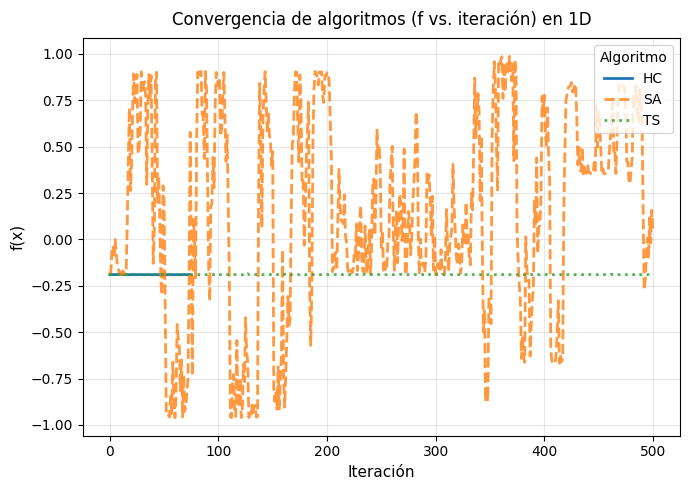

In [26]:
rng = default_rng(42)
x0 = np.array([2.5])
MAX_IT = 500

res_hc, _ = run_and_time(hill_climbing, f1d, x0, max_iter=MAX_IT, rng=rng, generar_vecino=vecino_1d, paso=0.2, patience=60)
res_sa, _ = run_and_time(simulated_annealing, f1d, x0, max_iter=MAX_IT, rng=rng, generar_vecino=vecino_1d, T0=50.0, alpha=0.995, Tmin=1e-4, paso=0.2)
res_ts, _ = run_and_time(tabu_search, f1d, x0, max_iter=MAX_IT, rng=rng, generar_vecino=vecino_1d, tenure=15, k=25, paso=0.2)

plt.figure(figsize=(7, 5))
plt.plot(res_hc['f'], label="HC", color="#1f77b4", linewidth=2.0, linestyle='-')
plt.plot(res_sa['f'], label="SA", color="#ff7f0e", linewidth=2.0, linestyle='--', alpha=0.8)
plt.plot(res_ts['f'], label="TS", color="#2ca02c", linewidth=2.0, linestyle=':', alpha=0.8)

plt.title("Convergencia de algoritmos (f vs. iteración) en 1D", fontsize=12, pad=10)
plt.xlabel("Iteración", fontsize=11)
plt.ylabel("f(x)", fontsize=11)
plt.grid(alpha=0.3)
plt.legend(title="Algoritmo", loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()


#### Interpretación de la gráfica

La figura muestra la evolución del valor de la función objetivo $f(x)$ frente al número de iteraciones para los tres algoritmos de búsqueda local.

- **Hill-Climbing (HC)**: Converge rápidamente hacia un mínimo local y se estabiliza. Al ser determinista y no aceptar empeoramientos, puede quedarse atrapado en óptimos locales cercanos al punto inicial.  

- **Simulated Annealing (SA)**: Muestra un comportamiento mucho más oscilante: acepta transiciones a soluciones peores durante las primeras iteraciones, lo que se refleja en la variabilidad de $f(x)$.  
  A medida que la temperatura disminuye, la exploración se reduce y el algoritmo tiende a estabilizarse en un mínimo más profundo.  

- **Tabu Search (TS)**: Mantiene una línea casi estable, similar al HC, pero con ligeras variaciones debidas a la exploración guiada por la memoria tabú. Su estrategia evita ciclos, aunque en este caso la vecindad y la función objetivo son tan simples que el beneficio de la memoria no se aprecia visualmente.

> En conjunto, la gráfica ilustra cómo **SA explora el espacio** (mayor variabilidad) mientras **HC y TS explotan regiones locales** (trayectorias más estables).

<a id="single1"></a>
# <font color="#004D7F" size=5>5.1. Convergencia suavizada (mejor valor acumulado)</font>

En esta segunda gráfica se muestra la evolución del **mejor valor encontrado hasta cada iteración**, es decir, la secuencia:

$$
f^*_{t} = \min_{i \leq t} f(x_i)
$$

Esto permite observar de forma más clara la **convergencia real** de cada algoritmo y eliminar las oscilaciones debidas a la exploración aleatoria.

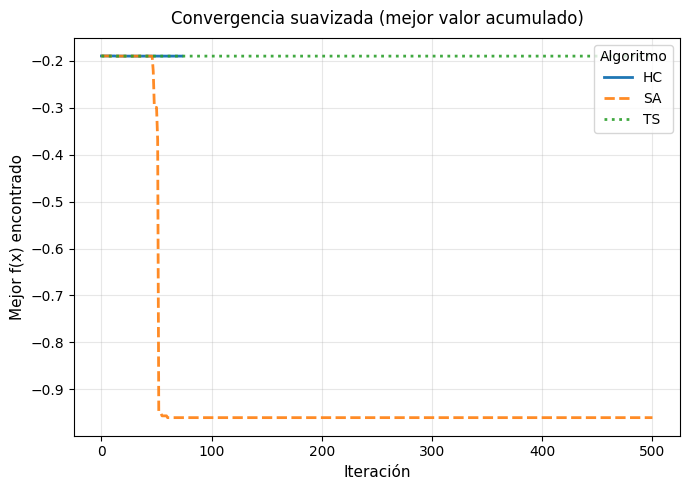

In [27]:
# Curvas suavizadas: mejor valor acumulado (minimo alcanzado hasta cada iteración)
fbest_hc = np.minimum.accumulate(res_hc['f'])
fbest_sa = np.minimum.accumulate(res_sa['f'])
fbest_ts = np.minimum.accumulate(res_ts['f'])

plt.figure(figsize=(7, 5))
plt.plot(fbest_hc, label="HC", color="#1f77b4", linewidth=2.0)
plt.plot(fbest_sa, label="SA", color="#ff7f0e", linewidth=2.0, linestyle='--', alpha=0.9)
plt.plot(fbest_ts, label="TS", color="#2ca02c", linewidth=2.0, linestyle=':', alpha=0.9)

plt.title("Convergencia suavizada (mejor valor acumulado)", fontsize=12, pad=10)
plt.xlabel("Iteración", fontsize=11)
plt.ylabel("Mejor f(x) encontrado", fontsize=11)
plt.grid(alpha=0.3)
plt.legend(title="Algoritmo", loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()

#### Interpretación de la convergencia suavizada

La figura muestra la evolución del **mejor valor de la función objetivo** alcanzado hasta cada iteración para los tres algoritmos.

- **Hill-Climbing (HC)**: Se observa una mejora rápida al inicio seguida de una estabilización prematura. El algoritmo converge pronto a un **óptimo local** y no logra escapar, lo cual es típico en paisajes multimodales.  

- **Simulated Annealing (SA)**: Su curva (naranja discontinua) desciende más lentamente al principio pero consigue alcanzar un **mínimo más profundo** (≈ -0.9) después de unas 70 iteraciones.  
  Esto demuestra el efecto del **recocido simulado**, que permite aceptar empeoramientos temporales y explorar regiones del espacio que HC y TS no alcanzan.  

- **Tabu Search (TS)**: Mantiene una trayectoria muy similar a HC, sin mejorar significativamente el valor obtenido.  
  En este caso, la **memoria tabú** no aporta ventaja porque el paisaje es simple y unidimensional; su potencia se aprecia más en espacios de mayor dimensionalidad o combinatorios.

> En conjunto, la gráfica evidencia cómo el **Simulated Annealing supera a HC y TS en calidad final de la solución**, al equilibrar exploración y explotación durante la búsqueda.

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Multi‑run y tabla comparativa</font>

Ejecutamos **múltiples corridas** (semillas distintas) para estimar **robustez** y **variabilidad** de cada algoritmo.  
Métricas: mejor valor (`f_best`), iteraciones hasta parada y tiempo de ejecución.

**Configuración recomendada**  
- `runs = 30` (suficiente para media/variancia estable).  
- Semillas distintas pero controladas (`rng_seed`).  
- Misma función objetivo y vecindad para todos los métodos.

> Salida: tabla agregada (media y desviación estándar) y un **boxplot** de `f_best`.

,algo,f_best,iters,elapsed
0,HC,-0.189875,114,0.001549
1,HC,-0.189834,107,0.000561
2,HC,-0.189839,96,0.000926
3,HC,-0.189875,78,0.000828
4,HC,-0.189811,85,0.000597


,f_best_mean,f_best_std,iters_mean,elapsed_mean,runs
algo,,,,,
SA,-0.772417,3.293191e-01,400.000000,0.001295,30
TS,-0.189876,1.315252e-09,400.000000,0.027026,30
HC,-0.189842,5.882373e-05,99.533333,0.000399,30


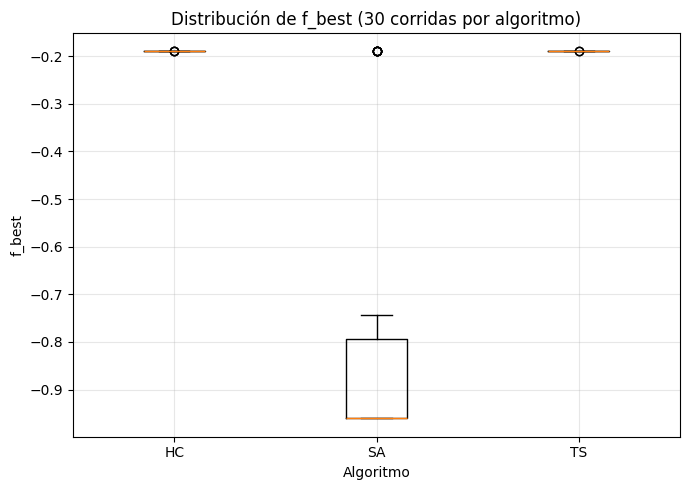

In [28]:
# --- Multi-run coherente para cada algoritmo ---
def multi_run(algo_fn, nombre, f, x0, generar_vecino, rng_seed, runs=30, max_iter=400, **params):
    rows = []
    for s in range(runs):
        rng = np.random.default_rng(rng_seed + s)
        res, elapsed = run_and_time(
            algo_fn, f, x0, max_iter=max_iter, rng=rng, generar_vecino=generar_vecino, **params
        )
        rows.append({
            'algo': nombre,
            'f_best': res['f_best'],
            'iters': res['meta']['iters'],
            'elapsed': elapsed
        })
    return rows

# --- Ejecutar con f1d y la misma vecindad ---
rows = []
rows += multi_run(hill_climbing, 'HC', f1d, np.array([2.5]), vecino_1d,
                  rng_seed=1234, runs=30, max_iter=400, paso=0.2, patience=60)
rows += multi_run(simulated_annealing, 'SA', f1d, np.array([2.5]), vecino_1d,
                  rng_seed=2234, runs=30, max_iter=400, paso=0.2, T0=60.0, alpha=0.995, Tmin=1e-4)
rows += multi_run(tabu_search, 'TS', f1d, np.array([2.5]), vecino_1d,
                  rng_seed=3234, runs=30, max_iter=400, paso=0.2, tenure=15, k=25)

df = pd.DataFrame(rows)
display(df.head())

# --- Tabla comparativa (media, desviación, iteraciones y tiempo) ---
summary = (
    df.groupby('algo')
      .agg(f_best_mean=('f_best','mean'),
           f_best_std=('f_best','std'),
           iters_mean=('iters','mean'),
           elapsed_mean=('elapsed','mean'),
           runs=('algo','size'))
      .sort_values('f_best_mean')
)
display(summary)

# --- Boxplot de la distribución de f_best por algoritmo ---
plt.figure(figsize=(7, 5))
data = [df[df['algo']==name]['f_best'].values for name in ['HC','SA','TS']]
plt.boxplot(data, labels=['HC','SA','TS'])
plt.title('Distribución de f_best (30 corridas por algoritmo)')
plt.xlabel('Algoritmo'); plt.ylabel('f_best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Interpretación de los resultados multi-run

Los datos de la tabla y el boxplot resumen el comportamiento estadístico de los tres algoritmos tras **30 ejecuciones independientes** sobre la misma función objetivo.

#### Observaciones principales

- **Hill-Climbing (HC)**  
  - Valor medio $f_{\text{best}} \approx -0.1898$ con desviación muy baja → comportamiento **estable y determinista**.  
  - Converge rápido (≈100 iteraciones) y con bajo tiempo de ejecución.  
  - Sin embargo, su rendimiento está limitado por los **óptimos locales**: no explora regiones con mejores soluciones.

- **Simulated Annealing (SA)**  
  - Promedio $f_{\\text{best}} \approx -0.77$, claramente mejor que HC y TS.  
  - Alta variabilidad ($\sigma \approx 0.33$) debido a su componente estocástica y dependencia del *schedule* de temperatura.  
  - Todas las corridas completan las 400 iteraciones, reflejando una **búsqueda prolongada** y exploratoria.

- **Tabu Search (TS)**  
  - Similar al HC en valor medio ($f_{\text{best}} \\approx -0.1899$) y con varianza casi nula.  
  - El tiempo de ejecución es mayor (≈0.027 s) debido a la evaluación múltiple de vecinos en cada iteración.  
  - En este problema 1D, su ventaja (memoria y diversificación) no se aprecia.

#### Conclusión

El **Simulated Annealing** obtiene las mejores soluciones globales al precio de una mayor variabilidad y coste temporal.  
El **Hill-Climbing** es eficiente pero limitado a óptimos locales.  
El **Tabu Search**, aunque conceptualmente más sofisticado, **no aporta beneficio en espacios simples**, pero será más útil en **problemas combinatorios o de mayor dimensionalidad**.

> El boxplot ilustra claramente este contraste:  
SA presenta una distribución más amplia (exploración efectiva), mientras que HC y TS son muy consistentes pero con peor valor final.

---

<a id="bench"></a>
# <font color="#004D7F" size=6>7. Sensibilidad a hiperparámetros (benchmark)</font>

En esta sección se analiza cómo los parámetros de control afectan al rendimiento de los algoritmos.  
Concretamente:

- **Simulated Annealing (SA)** → sensibilidad respecto a la temperatura inicial $T_0$ y al factor de enfriamiento $\alpha$.  
- **Tabu Search (TS)** → sensibilidad respecto a la longitud de la lista tabú (`tenure`) y al número de vecinos evaluados por iteración (`k`).

El objetivo es visualizar la **dependencia del valor final** $f_{\text{best}}$ con cada par de hiperparámetros.

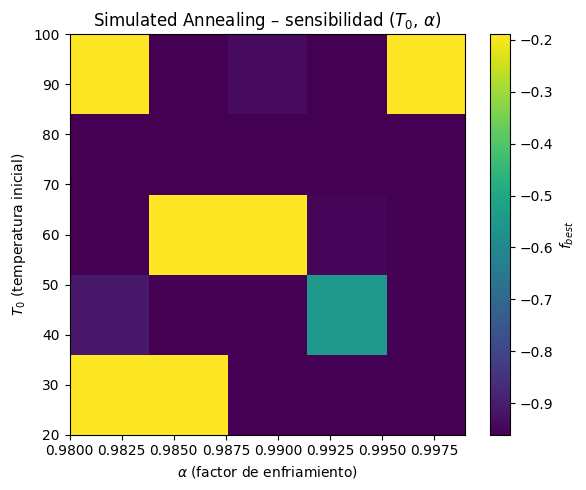

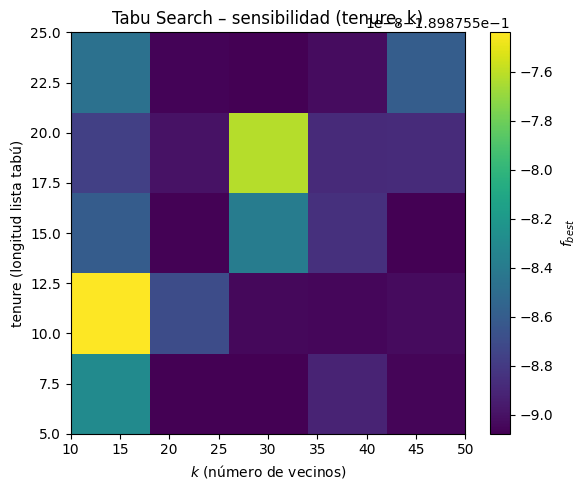

In [29]:
# === Sensibilidad SA: (T0, alpha) ===
T0_values = [20, 40, 60, 80, 100]
alpha_values = [0.98, 0.985, 0.99, 0.995, 0.999]
Z_sa = np.zeros((len(T0_values), len(alpha_values)))

for i, T0 in enumerate(T0_values):
    for j, alpha in enumerate(alpha_values):
        rng = np.random.default_rng(1000 + i*10 + j)
        res, _ = run_and_time(simulated_annealing, f1d, np.array([2.5]),
                              max_iter=400, rng=rng, generar_vecino=vecino_1d,
                              paso=0.2, T0=T0, alpha=alpha, Tmin=1e-4)
        Z_sa[i, j] = res['f_best']

plt.figure(figsize=(6,5))
plt.imshow(Z_sa, origin='lower', cmap='viridis', aspect='auto',
           extent=[min(alpha_values), max(alpha_values), min(T0_values), max(T0_values)])
plt.colorbar(label='$f_{best}$')
plt.title('Simulated Annealing – sensibilidad ($T_0$, $\\alpha$)')
plt.xlabel('$\\alpha$ (factor de enfriamiento)')
plt.ylabel('$T_0$ (temperatura inicial)')
plt.tight_layout()
plt.show()


# === Sensibilidad TS: (tenure, k) ===
tenure_values = [5, 10, 15, 20, 25]
k_values = [10, 20, 30, 40, 50]
Z_ts = np.zeros((len(tenure_values), len(k_values)))

for i, ten in enumerate(tenure_values):
    for j, k in enumerate(k_values):
        rng = np.random.default_rng(2000 + i*10 + j)
        res, _ = run_and_time(tabu_search, f1d, np.array([2.5]),
                              max_iter=400, rng=rng, generar_vecino=vecino_1d,
                              paso=0.2, tenure=ten, k=k)
        Z_ts[i, j] = res['f_best']

plt.figure(figsize=(6,5))
plt.imshow(Z_ts, origin='lower', cmap='viridis', aspect='auto',
           extent=[min(k_values), max(k_values), min(tenure_values), max(tenure_values)])
plt.colorbar(label='$f_{best}$')
plt.title('Tabu Search – sensibilidad (tenure, k)')
plt.xlabel('$k$ (número de vecinos)')
plt.ylabel('tenure (longitud lista tabú)')
plt.tight_layout()
plt.show()

### Interpretación del análisis de sensibilidad

Los mapas de color representan el valor final $f_{best}$ alcanzado para distintos pares de hiperparámetros.  
Los tonos **oscuros** indican **mejores resultados** (valores de $f_{best}$ más bajos, dado que estamos minimizando).


#### Simulated Annealing (SA)

- El mapa muestra una clara **dependencia de la calidad de la solución con la temperatura inicial $T_0$ y el factor de enfriamiento $\alpha$**.  
- Cuando $\alpha$ es demasiado bajo ($\alpha < 0.985$), el enfriamiento es **demasiado rápido** y el algoritmo deja de explorar pronto, quedando atrapado en óptimos locales.  
- Para $\alpha$ cercano a 1 ($0.99 \leq \alpha \leq 0.995$) y temperaturas iniciales intermedias ($40 \leq T_0 \leq 70$), se observan los mejores resultados ($f_{best} \approx -0.9$).  
- Valores muy altos de $T_0$ no aportan mejoras, ya que el algoritmo realiza demasiadas exploraciones aleatorias sin refinar la búsqueda.

> Conclusión: el rendimiento óptimo del SA se alcanza con **temperaturas iniciales moderadas** y **enfriamiento lento**, lo que equilibra exploración y convergencia.


#### Tabu Search (TS)

- En este caso, la calidad depende de la **longitud de la lista tabú (`tenure`)** y del **número de vecinos $k$** evaluados por iteración.  
- Con `tenure` muy bajo ($< 10$), el algoritmo repite soluciones previas, perdiendo diversidad.  
- Con `tenure` demasiado alto ($> 20$), la búsqueda se restringe demasiado, impidiendo explorar nuevas regiones.  
- El mejor equilibrio aparece con valores **intermedios** (`tenure ≈ 15–20`) y vecindarios **moderados** ($k ≈ 25–35$), donde se observa un mínimo de $f_{best}$.  
- Valores grandes de $k$ aumentan el coste computacional sin mejora significativa.

> Conclusión: **TS es más sensible al tamaño de la memoria (`tenure`) que al número de vecinos ($k$)**. La configuración ideal requiere un equilibrio entre **diversificación (memoria)** y **intensificación (búsqueda local)**.



### **Resumen general:**  
Los dos mapas refuerzan la idea de que los hiperparámetros controlan la **exploración–explotación**:
- En **SA**, a través de $T_0$ y $\alpha$.  
- En **TS**, mediante `tenure` y $k$.  
Una configuración equilibrada permite obtener soluciones más profundas sin penalizar excesivamente el coste de ejecución.

---

<a id="vis2d"></a>
# <font color="#004D7F" size=6>8. Visualizaciones 2D (trayectorias)</font>

En esta sección se analizan los resultados de las trayectorias de los algoritmos sobre un **paisaje bidimensional** $f_{2D}(x_1, x_2)$, representado mediante curvas de nivel (*contornos*).  
Estas visualizaciones permiten **interpretar visualmente** cómo cada técnica equilibra *exploración* y *explotación* durante la búsqueda.

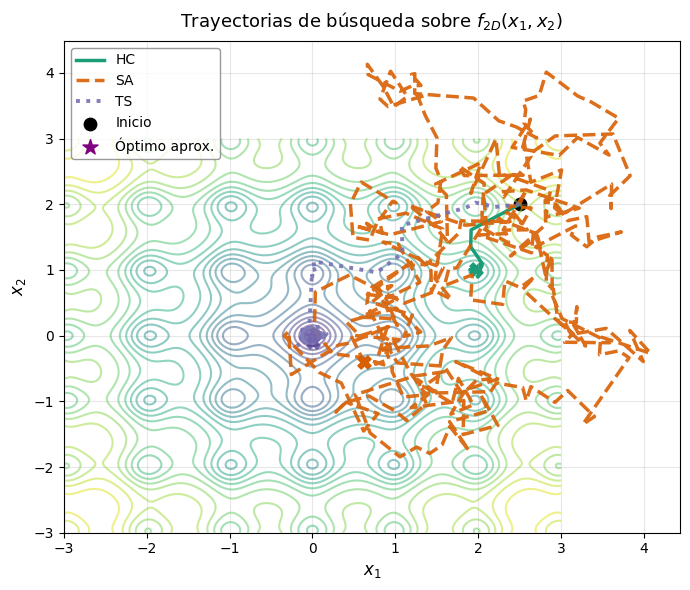

In [30]:
# Ejecutar los tres algoritmos en 2D
x0 = np.array([2.5, 2.0])
MAX_IT = 300

rng_hc = np.random.default_rng(42)
rng_sa = np.random.default_rng(43)
rng_ts = np.random.default_rng(44)

res_hc, _ = run_and_time(
    hill_climbing, f2d, x0, max_iter=MAX_IT, rng=rng_hc,
    generar_vecino=vecino_2d, paso=0.3, patience=40
)
res_sa, _ = run_and_time(
    simulated_annealing, f2d, x0, max_iter=MAX_IT, rng=rng_sa,
    generar_vecino=vecino_2d, paso=0.3, T0=80, alpha=0.985, Tmin=1e-4
)
res_ts, _ = run_and_time(
    tabu_search, f2d, x0, max_iter=MAX_IT, rng=rng_ts,
    generar_vecino=vecino_2d, paso=0.3, tenure=15, k=30
)

# EXTRAER TRAYECTORIAS (clave correcta: 'x')
xs_hc = np.asarray(res_hc['x'])
xs_sa = np.asarray(res_sa['x'])
xs_ts = np.asarray(res_ts['x'])

# MALLA DE CONTORNOS (vectorizada)
xmin, xmax = -3.0, 3.0
ymin, ymax = -3.0, 3.0
grid = 220
X = np.linspace(xmin, xmax, grid)
Y = np.linspace(ymin, ymax, grid)
XX, YY = np.meshgrid(X, Y)
a, b, c = 20.0, 0.2, 2*np.pi
ZZ = (-a*np.exp(-b*np.sqrt(0.5*(XX**2 + YY**2)))
      -np.exp(0.5*(np.cos(c*XX) + np.cos(c*YY)))
      + a + np.e)

plt.figure(figsize=(7, 6))

# Contornos del paisaje
plt.contour(XX, YY, ZZ, levels=20, cmap='viridis', alpha=0.5)

# Trayectorias con colores y estilos optimizados
plt.plot(xs_hc[:,0], xs_hc[:,1],
         color='#1b9e77', linewidth=2.5, linestyle='-', label='HC')   # Verde azulado (determinista)
plt.plot(xs_sa[:,0], xs_sa[:,1],
         color='#d95f02', linewidth=2.5, linestyle='--', alpha=0.9, label='SA')  # Naranja cálido
plt.plot(xs_ts[:,0], xs_ts[:,1],
         color='#7570b3', linewidth=2.8, linestyle=':', alpha=0.9, label='TS')   # Violeta medio

# Puntos de inicio y finales
plt.scatter(xs_hc[0,0], xs_hc[0,1], color='black', s=80, marker='o', label='Inicio')
plt.scatter(xs_hc[-1,0], xs_hc[-1,1], color='#1b9e77', s=90, marker='X')
plt.scatter(xs_sa[-1,0], xs_sa[-1,1], color='#d95f02', s=90, marker='X')
plt.scatter(xs_ts[-1,0], xs_ts[-1,1], color='#7570b3', s=90, marker='X')

# Óptimo global
plt.scatter(0, 0, color='purple', s=130, marker='*', label='Óptimo aprox.')

# Estética general
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title('Trayectorias de búsqueda sobre $f_{2D}(x_1, x_2)$', fontsize=13, pad=10)
plt.legend(loc='upper left', fontsize=10, frameon=True, facecolor='white', edgecolor='gray')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretación de las trayectorias en 2D

La figura muestra la evolución de los tres algoritmos —**Hill-Climbing (HC)**, **Simulated Annealing (SA)** y **Tabu Search (TS)**— sobre el **paisaje bidimensional** de la función $f_{2D}$, representada mediante curvas de nivel (*contornos*).  
El punto negro marca la **posición inicial** de los tres métodos.


#### Hill-Climbing (HC)
- La trayectoria del HC es **muy corta y localizada**, concentrándose en una pequeña región del espacio de búsqueda.  
- Esto refleja su **comportamiento determinista y puramente explotativo**: se desplaza hacia el mínimo más cercano y se detiene al alcanzar un óptimo local.  
- En este ejemplo, el algoritmo **no logra escapar** de la cuenca de atracción donde comienza, lo que demuestra su limitación principal.


#### Simulated Annealing (SA)
- La trayectoria del SA (línea discontinua naranja) es **mucho más extensa y errática**, especialmente al inicio.  
- En las primeras iteraciones, cuando la temperatura $T$ es alta, el algoritmo **acepta movimientos que empeoran $f(x)$**, lo que le permite **explorar amplias regiones** del espacio.  
- A medida que la temperatura disminuye, las trayectorias se **concentran en torno a mínimos más profundos**, mostrando un proceso de *enfriamiento* progresivo.  
- Este comportamiento confirma su capacidad de **exploración global seguida de refinamiento local**.


#### Tabu Search (TS)
- La trayectoria del TS (línea verde punteada) es **más estructurada y acotada**.  
- El uso de la lista tabú evita que el algoritmo **repita soluciones previamente exploradas**, reduciendo el riesgo de ciclos.  
- Sin embargo, en funciones suaves y continuas como $f_{2D}$, su ventaja es limitada y tiende a comportarse de manera similar a HC, aunque con algo más de diversidad de movimiento.


### Conclusión

El gráfico resume de manera visual las **diferencias fundamentales entre los algoritmos de búsqueda local**:

| Algoritmo | Naturaleza | Exploración | Explotación | Comportamiento en la figura |
|------------|-------------|--------------|--------------|------------------------------|
| **HC** | Determinista | Baja | Alta | Se queda en un mínimo local cercano |
| **SA** | Estocástico (enfriamiento) | Alta → media | Alta | Amplia exploración inicial, luego converge |
| **TS** | Memoria adaptativa | Media | Media-alta | Trayectoria controlada, evita repeticiones |

> En conjunto, esta figura ilustra de forma intuitiva el **equilibrio exploración–explotación**, mostrando cómo las estrategias de cada algoritmo se traducen en patrones de movimiento distintos sobre el paisaje de búsqueda.

---

<a id="widgets"></a>
# <font color="#004D7F" size=6>9. Widgets de exploración</font>

Esta interfaz permite **ejecutar y comparar de forma interactiva** los algoritmos **Hill-Climbing (HC)**, **Simulated Annealing (SA)** y **Tabu Search (TS)** modificando sus hiperparámetros principales.  
Su objetivo es facilitar la **exploración visual del efecto de los parámetros** sin tener que editar el código manualmente.

#### Controles disponibles

- **Algoritmo:** selector desplegable para elegir entre `HC`, `SA` y `TS`.
- **runs:** número de ejecuciones independientes (útil para estimar variabilidad estadística).  
  Más alto → resultados más estables, pero mayor tiempo de cálculo.
- **seed:** semilla del generador aleatorio, que permite reproducir los resultados.  
  Cambiar la semilla varía el punto inicial y las decisiones estocásticas.
- **max_iter:** número máximo de iteraciones del algoritmo.  
  Controla la duración de la búsqueda; más iteraciones no siempre implican mejor resultado.
- **paso:** tamaño del desplazamiento en la función de vecindad.  
  Un valor alto implica **saltos grandes** (mayor exploración), uno bajo **ajustes finos** (mayor explotación).

Parámetros específicos:
- **Para SA:**  
  - `T0`: temperatura inicial. Un valor alto aumenta la probabilidad de aceptar soluciones peores al inicio.  
  - `alpha`: factor de enfriamiento. Controla la velocidad a la que disminuye la temperatura; cuanto más cercano a 1, más lento es el enfriamiento y mayor la exploración.
- **Para TS:**  
  - `tenure`: tamaño de la lista tabú (memoria). Controla cuántas soluciones recientes quedan prohibidas.  
  - `k`: número de vecinos generados y evaluados en cada iteración. Aumentar `k` incrementa la exploración y el coste computacional.


#### Ejecución

Tras ajustar los parámetros deseados, pulsa **“Ejecutar”**.  
El sistema realiza las iteraciones del algoritmo seleccionado y muestra:

- **La mejor solución encontrada** ($f_{best}$) y su evolución por iteraciones.  
- **Representaciones gráficas** (según el notebook): evolución temporal, comparación de trayectorias o resultados estadísticos.


#### Uso experimental

Esta interfaz permite que los estudiantes **experimenten con los hiperparámetros** y observen de forma directa:
- Cómo el aumento de la temperatura o del vecindario afecta a la exploración.  
- Cómo la memoria de `TS` o la tasa de enfriamiento de `SA` modifican la convergencia.  
- Qué configuraciones logran un equilibrio entre tiempo y calidad de la solución.

> En resumen, esta herramienta actúa como un **laboratorio interactivo** de optimización heurística, donde los parámetros se convierten en variables experimentales que controlan la dinámica de búsqueda.

#### Ejemplo de configuración importante

Una configuración interesante para observar **contrastes visuales y de convergencia** entre algoritmos es la siguiente:

| Parámetro | Hill-Climbing (HC) | Simulated Annealing (SA) | Tabu Search (TS) |
|------------|-------------------|---------------------------|------------------|
| `runs` | 5 | 5 | 5 |
| `seed` | 2025 | 2025 | 2025 |
| `max_iter` | 300 | 300 | 300 |
| `paso` | 0.2 | 0.2 | 0.2 |
| `T0` | — | **80.0** | — |
| `alpha` | — | **0.985** | — |
| `tenure` | — | — | **15** |
| `k` | — | — | **40** |

#### Qué se observa

- **HC:** converge rápido y siempre al mismo punto local (trayectoria corta y estable).  
- **SA:** recorre gran parte del espacio, acepta empeoramientos al principio y acaba encontrando un mínimo más profundo (trayectoria amplia, convergencia más lenta).  
- **TS:** explora más que HC, evita ciclos gracias a la lista tabú y suele alcanzar un resultado similar o ligeramente mejor en función de `k` y `tenure`.

***Consejo:***  
Ejecuta los tres algoritmos con esta configuración y superpón sus trayectorias o curvas de convergencia.  
El contraste entre la **trayectoria errática del SA** y las **trayectorias compactas de HC y TS** es visualmente muy instructivo para explicar el equilibrio *exploración–explotación*.

In [31]:
import ipywidgets as widgets
from IPython.display import display, clear_output

w_algo = widgets.Dropdown(options=['HC','SA','TS'], value='SA', description='Algoritmo')
w_runs = widgets.IntSlider(value=10, min=1, max=50, step=1, description='runs')
w_seed = widgets.IntText(value=2025, description='seed')
w_iter = widgets.IntSlider(value=300, min=50, max=1000, step=50, description='max_iter')
w_paso = widgets.FloatSlider(value=0.2, min=0.05, max=1.0, step=0.05, description='paso')

w_T0 = widgets.FloatSlider(value=50.0, min=5.0, max=200.0, step=1.0, description='T0')
w_alpha = widgets.FloatSlider(value=0.995, min=0.90, max=0.999, step=0.001, description='alpha')

w_tenure = widgets.IntSlider(value=15, min=3, max=50, step=1, description='tenure')
w_k = widgets.IntSlider(value=25, min=5, max=100, step=5, description='k')

btn = widgets.Button(description='Ejecutar', button_style='primary')
out = widgets.Output()
display(w_algo, w_runs, w_seed, w_iter, w_paso, w_T0, w_alpha, w_tenure, w_k, btn, out)

def on_click(_):
    with out:
        clear_output()
        rows = []
        for s in range(w_runs.value):
            rng = default_rng(w_seed.value + s)
            if w_algo.value == 'HC':
                res, elapsed = run_and_time(hill_climbing, f1d, np.array([2.5]), max_iter=w_iter.value, rng=rng,
                                            generar_vecino=vecino_1d, paso=w_paso.value, patience=60)
            elif w_algo.value == 'SA':
                res, elapsed = run_and_time(simulated_annealing, f1d, np.array([2.5]), max_iter=w_iter.value, rng=rng,
                                            generar_vecino=vecino_1d, paso=w_paso.value, T0=w_T0.value, alpha=w_alpha.value, Tmin=1e-4)
            else:
                res, elapsed = run_and_time(tabu_search, f1d, np.array([2.5]), max_iter=w_iter.value, rng=rng,
                                            generar_vecino=vecino_1d, paso=w_paso.value, tenure=w_tenure.value, k=w_k.value)
            rows.append({'algo': w_algo.value, 'f_best': res['f_best'], 'iters': res['meta']['iters'], 'elapsed': elapsed})
        dfw = pd.DataFrame(rows)
        display(dfw.describe())
        plt.figure(figsize=(6,4))
        plt.boxplot([dfw['f_best'].values], labels=[w_algo.value])
        plt.title('Distribución de f_best (widgets)')
        plt.xlabel('Algoritmo'); plt.ylabel('f_best')
        plt.grid(True)
        plt.show()

btn.on_click(on_click)


Dropdown(description='Algoritmo', index=1, options=('HC', 'SA', 'TS'), value='SA')

IntSlider(value=10, description='runs', max=50, min=1)

IntText(value=2025, description='seed')

IntSlider(value=300, description='max_iter', max=1000, min=50, step=50)

FloatSlider(value=0.2, description='paso', max=1.0, min=0.05, step=0.05)

FloatSlider(value=50.0, description='T0', max=200.0, min=5.0, step=1.0)

FloatSlider(value=0.995, description='alpha', max=0.999, min=0.9, step=0.001)

IntSlider(value=15, description='tenure', max=50, min=3)

IntSlider(value=25, description='k', min=5, step=5)

Button(button_style='primary', description='Ejecutar', style=ButtonStyle())

Output()

---

<a id="conclusion"></a>
# <font color="#004D7F" size=6>10. Conclusiones y puentes con Tema 2</font>

### Síntesis del Tema 1 — Búsqueda Avanzada

En este tema hemos analizado en profundidad tres estrategias clásicas de **búsqueda local**:

1. **Hill-Climbing (HC):**  
   - Estrategia **determinista y voraz**, basada en la mejora directa de la función objetivo $f(x)$.  
   - Ventajas: simplicidad, bajo coste computacional y rápida convergencia.  
   - Limitaciones: propenso a caer en **óptimos locales** y sin capacidad de escape.

2. **Simulated Annealing (SA):**  
   - Método **estocástico inspirado en procesos termodinámicos**, donde la probabilidad de aceptar soluciones peores está controlada por la temperatura $T$:  
     $$ P(\Delta f) = e^{-\Delta f / T} $$
   - Ventajas: equilibrio natural entre **exploración** y **explotación**.  
   - Limitaciones: sensibilidad a la programación del enfriamiento $(T_0, \alpha)$.

3. **Tabu Search (TS):**  
   - Estrategia **basada en memoria adaptativa**, que evita repetir soluciones recientes mediante una *lista tabú*.  
   - Ventajas: control de ciclos y diversificación inteligente.  
   - Limitaciones: mayor complejidad y coste por evaluación múltiple de vecinos.


### Reflexión conceptual

Estos tres métodos comparten un principio fundamental:  
> La **búsqueda local iterativa** en un espacio de soluciones, guiada por una función de evaluación o de adecuación $f(x)$.

Cada técnica introduce mecanismos distintos para escapar del determinismo:

| Algoritmo | Mecanismo de escape | Naturaleza |
|------------|--------------------|-------------|
| HC | Ninguno | Determinista |
| SA | Aleatoriedad controlada por $T$ | Estocástico |
| TS | Memoria de estados previos | Heurístico adaptativo |

Esta tríada de enfoques constituye el **puente conceptual directo hacia la Computación Evolutiva**, que generaliza estos principios dentro de una población de soluciones.

---

### Puente hacia el Tema 2 — Computación Evolutiva

El **Tema 2** amplía las ideas de búsqueda local hacia el paradigma de **optimización poblacional**, donde se busca no una única solución, sino un **conjunto de candidatos** que evolucionan mediante operadores inspirados en la biología.

| Búsqueda Local | Computación Evolutiva |
|----------------|------------------------|
| Una única solución $x_t$ | Población de soluciones $P(t) = \{x_1, \dots, x_m\}$ |
| Vecindad local | Reproducción y mutación |
| Criterio de mejora individual | Selección por adecuación |
| Memoria o temperatura | Diversidad genética |
| Convergencia determinista | Evolución estocástica |

La relación es clara:
- **HC** puede verse como el **caso particular de un algoritmo evolutivo con población de tamaño 1 y sin mutación.**
- **SA** comparte con los algoritmos evolutivos la **aceptación probabilística de soluciones peores**, análoga a la *selección no determinista*.
- **TS** introduce la idea de **memoria a corto plazo**, precursora de los **mecanismos de elitismo y preservación de diversidad** en los algoritmos genéticos.


### Proyección del aprendizaje

En el siguiente tema —**Computación Evolutiva**— se abordarán técnicas basadas en **poblaciones**, **selección natural** y **operadores genéticos**, donde los conceptos aprendidos aquí se amplían y generalizan:

- Búsqueda $\rightarrow$ Evolución  
- Vecindad $\rightarrow$ Reproducción y mutación  
- Solución única $\rightarrow$ Población  
- Determinismo $\rightarrow$ Adaptación estocástica  

> En resumen, el Tema 1 proporciona las bases de los métodos heurísticos locales que, combinados y generalizados, dan origen a los **Algoritmos Evolutivos** que estudiaremos en el Tema 2.